In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

df = yf.download('BTC-USD', start='2010-01-01',
                end=date.today())

#data.to_csv('../data/historical_yfinance/btc_usd.csv')


[*********************100%***********************]  1 of 1 completed


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2778 entries, 2014-09-17 to 2022-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2778 non-null   float64
 1   High       2778 non-null   float64
 2   Low        2778 non-null   float64
 3   Close      2778 non-null   float64
 4   Adj Close  2778 non-null   float64
 5   Volume     2778 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.9 KB


In [59]:
#df = pd.read_csv('../data/historical_yfinance/btc_usd.csv')
df = df.reset_index()

In [60]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2773,2022-04-21,41371.515625,42893.582031,40063.828125,40527.363281,40527.363281,35372786395
2774,2022-04-22,40525.863281,40777.757812,39315.417969,39740.320312,39740.320312,28011716745
2775,2022-04-23,39738.722656,39935.859375,39352.203125,39486.730469,39486.730469,16138021249
2776,2022-04-24,39478.375000,39845.925781,39233.539062,39469.292969,39469.292969,17964398167


In [61]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [62]:
prediction_days = 60 #Number of past days to take into account to calculate the prediction

x_train, y_train = [], []
for x in range (prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [63]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50)) 
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
85/85 [==============================] - 9s 57ms/step - loss: 0.0062
Epoch 2/25
85/85 [==============================] - 4s 50ms/step - loss: 0.0024
Epoch 3/25
85/85 [==============================] - 4s 52ms/step - loss: 0.0022
Epoch 4/25
85/85 [==============================] - 5s 61ms/step - loss: 0.0018
Epoch 5/25
85/85 [==============================] - 4s 48ms/step - loss: 0.0016
Epoch 6/25
85/85 [==============================] - 4s 50ms/step - loss: 0.0016
Epoch 7/25
85/85 [==============================] - 4s 50ms/step - loss: 0.0016
Epoch 8/25
85/85 [==============================] - 5s 56ms/step - loss: 0.0016
Epoch 9/25
85/85 [==============================] - 4s 51ms/step - loss: 0.0014
Epoch 10/25
85/85 [==============================] - 4s 51ms/step - loss: 0.0012
Epoch 11/25
85/85 [==============================] - 4s 51ms/step - loss: 0.0016
Epoch 12/25
85/85 [==============================] - 4s 52ms/step - loss: 0.0013
Epoch 13/25
85/85 [==================

In [188]:
test_data = yf.download('BTC-USD', start='2020-01-01',
                end=date.today())
test_data = test_data.reset_index()
actual_prices = test_data['Close'].values

[*********************100%***********************]  1 of 1 completed


In [65]:
total_dataset = pd.concat((df['Close'], test_data['Close']), axis=0)

In [66]:
model_inputs = total_dataset[len(total_dataset)-len(test_data)- prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [67]:
x_test = []
for x in range (prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [168]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

/Users/ivan.repilado/miniconda3/envs/ih_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Unrecognized location 'uper left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



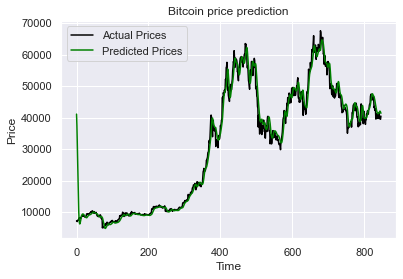

In [149]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('Bitcoin price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='uper left')
plt.show();

In [191]:
import plotly.graph_objects as go
import plotly.offline as pyo


# Create figure
fig = go.Figure()

actual_prices_plot = go.Scatter(name='Actual prices',x=test_data.Date, y=actual_prices)
prediction_prices_plot = go.Scatter(name='Predicted prices',x=test_data.Date, y=[i[0] for i in prediction_prices])

# Set title
fig.update_layout(title_text="Bitcoin price prediction")

data = [actual_prices_plot,prediction_prices_plot]
fig = dict(data=data)
pyo.iplot(fig, filename='temp1')


In [192]:
#Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs) +1 , 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [193]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

[[41097.066]]
